## Verificacao de Algoritmos

Neste notebook sera verificado o uso do algoritmo Word2Vec e Doc2Vec juntamente com o algoritmo de clusterizacao Spectral Clustering para um "treinamento" nao supervisionado.

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../../")

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from minisom import MiniSom
from gensim.models import Word2Vec, Doc2Vec

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))

['resposta cancer sinais sintomas que deve ficar atento emagrecer sem fazer dieta praticar exercicios cansaco intenso fazendo pequenas tarefas dor que nao passa febre que vai volta sem tomar remedio alteracoes nas fezes dor urinar urina escura'
 0]
2560


### Unsupervised Learning : Word2Vec +  Spectral Clustering

In [5]:
w2v = Word2Vec.load(f"{os.getcwd()}/../../ai/models/w2v.model")
print(f"Palavras no vocab: {len(list(w2v.wv.vocab))}")

# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format(f"{os.getcwd()}/../ai/models/skip_s300.txt")

Palavras no vocab: 260919


In [6]:
n_textos = []
for texto in textos:
    doc = []
    for palavra in texto[0].split():
        try:
            doc.append(w2v.wv[palavra])
        except:
            doc.append(np.zeros((300, )))
    doc = np.mean(doc, axis=0)
    n_textos.append(doc)
n_textos = np.asarray(n_textos)

In [7]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    euclidean_distances, 
    sigmoid_kernel, 
    polynomial_kernel,
    rbf_kernel,
    laplacian_kernel,
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1
        ))

In [8]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Metric"], ascending=False)
df.head(25)

,Metric,AssignLabels,Accuracy,F1
4,sigmoid_kernel,discretize,52.03,57.12
6,polynomial_kernel,discretize,52.03,57.12
5,sigmoid_kernel,kmeans,48.24,19.84
7,polynomial_kernel,kmeans,48.24,19.84
10,laplacian_kernel,discretize,59.96,7.07
11,laplacian_kernel,kmeans,60.00,6.91
8,rbf_kernel,discretize,60.23,5.04
9,rbf_kernel,kmeans,60.20,4.86
2,euclidean_distances,discretize,60.98,0.00
3,euclidean_distances,kmeans,60.98,0.00


              precision    recall  f1-score   support

           0       0.76      0.33      0.46      1578
           1       0.43      0.83      0.57       982

    accuracy                           0.52      2560
   macro avg       0.60      0.58      0.51      2560
weighted avg       0.63      0.52      0.50      2560



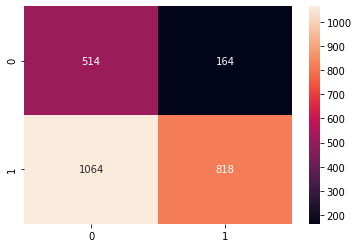

In [9]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(sigmoid_kernel(X))

pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Unsupervised Learning : Doc2Vec +  Spectral Clustering

In [10]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../../ai/models/d2v.model")

In [11]:
n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=500)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [12]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    euclidean_distances, 
    rbf_kernel,
    laplacian_kernel, 
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1
        ))

In [13]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Metric"], ascending=False)
df.reset_index().head(25)

,index,Metric,AssignLabels,Accuracy,F1
0,6,laplacian_kernel,discretize,53.63,51.49
1,4,rbf_kernel,discretize,48.28,15.99
2,5,rbf_kernel,kmeans,50.47,13.39
3,7,laplacian_kernel,kmeans,51.25,12.11
4,2,euclidean_distances,discretize,61.25,0.00
5,3,euclidean_distances,kmeans,61.25,0.00
6,1,cosine_distances,kmeans,61.25,0.00
7,0,cosine_distances,discretize,61.09,0.00


              precision    recall  f1-score   support

           0       0.68      0.47      0.56      1578
           1       0.43      0.64      0.51       982

    accuracy                           0.54      2560
   macro avg       0.55      0.56      0.54      2560
weighted avg       0.58      0.54      0.54      2560



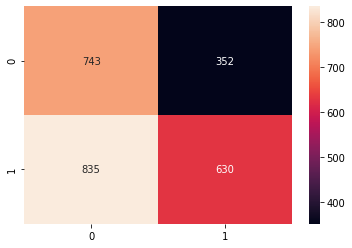

In [14]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(laplacian_kernel(X))

pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Unsupervised Learning : Doc2Vec +  SOM

In [15]:
def classify(som, data, class_assignments):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [16]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

som = MiniSom(150, 150, 300, activation_distance="cosine", sigma=1e-3, learning_rate=1e-3)
som.pca_weights_init(X_train)
som.train_random(X_train, 1000)

              precision    recall  f1-score   support

           0       0.59      0.99      0.74       302
           1       0.00      0.00      0.00       210

    accuracy                           0.59       512
   macro avg       0.29      0.50      0.37       512
weighted avg       0.35      0.59      0.44       512



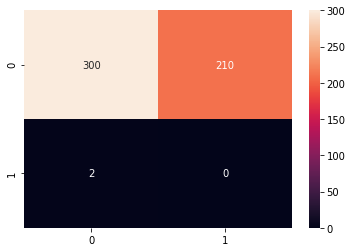

In [17]:
class_assignments = som.labels_map(X_train, y_train)
pred = classify(som, X_test, class_assignments)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

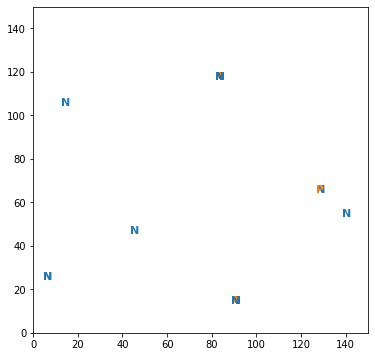

In [18]:
plt.figure(figsize=(6, 6))
wmap = {}
im = 0
for x, t in zip(X_test, y_test):
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5, "P" if t == 1 else "N",
              color=f"C{t}", fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

### Supervised Learning : Doc2Vec + Logistic Regression

              precision    recall  f1-score   support

           0       0.67      0.87      0.76       302
           1       0.68      0.39      0.49       210

    accuracy                           0.67       512
   macro avg       0.68      0.63      0.63       512
weighted avg       0.68      0.67      0.65       512



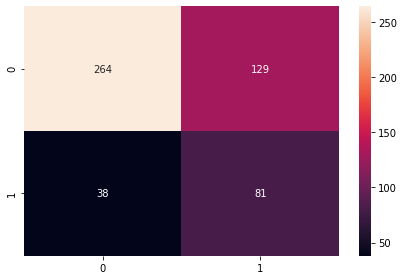

In [19]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = LogisticRegression(
    random_state=0,
    n_jobs=-1,
    max_iter=1000,
    multi_class="ovr"
).fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Doc2Vec + Ensemble

Cross Validation accuracy: 0.71 (+/- 0.05)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       302
           1       0.66      0.64      0.65       210

    accuracy                           0.71       512
   macro avg       0.71      0.70      0.70       512
weighted avg       0.71      0.71      0.71       512



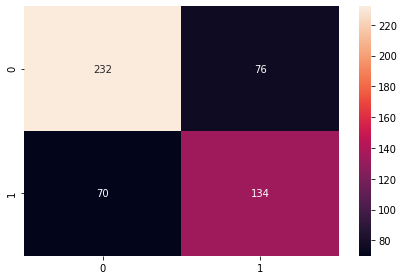

In [20]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf1 = LogisticRegression(random_state=0, n_jobs=-1, max_iter=1000, multi_class="ovr",)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

scores = cross_val_score(eclf, X_train, y_train, cv=5)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()